# Drug Consumption

## Data Understanding
### Import von benötigten Bibliotheken

In [210]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Datensatz abrufen

In [211]:
dataset = fetch_ucirepo(id=373)

### Daten (Features und Zielvariable)

In [212]:
X = dataset.data.features
X = X.drop(columns=['age', 'gender', 'ethnicity'])
y = dataset.data.targets

### Erste Übersicht der Features und der Zielvariablen

In [213]:
print("Übersicht der Merkmale:")
print(X.head())

print("")
print("Übersicht der Targets in den Zielklassen:")
print(y.head())

print("")
print("Übersicht über Datentypen im Datensatz")
print(X.dtypes)
print(y.dtypes)

Übersicht der Merkmale:
   education  country   nscore   escore   oscore   ascore   cscore  impuslive  \
0   -0.05921  0.96082  0.31287 -0.57545 -0.58331 -0.91699 -0.00665   -0.21712   
1    1.98437  0.96082 -0.67825  1.93886  1.43533  0.76096 -0.14277   -0.71126   
2   -0.05921  0.96082 -0.46725  0.80523 -0.84732 -1.62090 -1.01450   -1.37983   
3    1.16365  0.96082 -0.14882 -0.80615 -0.01928  0.59042  0.58489   -1.37983   
4    1.98437  0.96082  0.73545 -1.63340 -0.45174 -0.30172  1.30612   -0.21712   

        ss  
0 -1.18084  
1 -0.21575  
2  0.40148  
3 -1.18084  
4 -0.21575  

Übersicht der Targets in den Zielklassen:
  alcohol amphet amyl benzos caff cannabis choc coke crack ecstasy heroin  \
0     CL5    CL2  CL0    CL2  CL6      CL0  CL5  CL0   CL0     CL0    CL0   
1     CL5    CL2  CL2    CL0  CL6      CL4  CL6  CL3   CL0     CL4    CL0   
2     CL6    CL0  CL0    CL0  CL6      CL3  CL4  CL0   CL0     CL0    CL0   
3     CL4    CL0  CL0    CL3  CL5      CL2  CL4  CL2   CL0  

### Lage- und Streuungsmaße

In [214]:
print("Lage- und Streuungsmaße der Features:")
print(X.describe())

Lage- und Streuungsmaße der Features:
         education      country       nscore       escore       oscore  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean     -0.003806     0.355542     0.000047    -0.000163    -0.000534   
std       0.950078     0.700335     0.998106     0.997448     0.996229   
min      -2.435910    -0.570090    -3.464360    -3.273930    -3.273930   
25%      -0.611130    -0.570090    -0.678250    -0.695090    -0.717270   
50%      -0.059210     0.960820     0.042570     0.003320    -0.019280   
75%       0.454680     0.960820     0.629670     0.637790     0.723300   
max       1.984370     0.960820     3.273930     3.273930     2.901610   

            ascore       cscore    impuslive           ss  
count  1885.000000  1885.000000  1885.000000  1885.000000  
mean     -0.000245    -0.000386     0.007216    -0.003292  
std       0.997440     0.997523     0.954435     0.963701  
min      -3.464360    -3.464360    -2.555240    -2.0784

### Enthaltene Drogen im Datensatz

In [215]:
drug_columns = ['cannabis', 'coke', 'ecstasy', 'heroin', 'meth', 'mushrooms', 'nicotine', 'lsd', 'amphet', 'crack', 'alcohol']

### Primäre Auswahl an zu analysierenden Drogen

In [216]:
chosen_drugs = ['cannabis', 'coke', 'nicotine'] 

### Visualisierung der Verteilung des Konsums für jede Droge

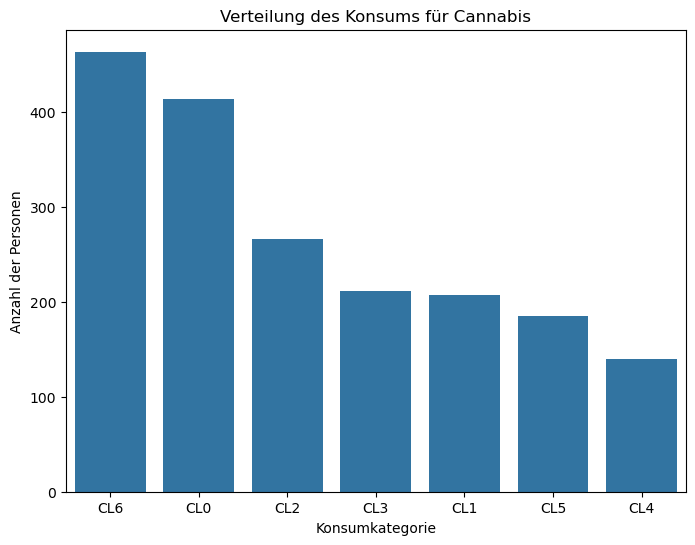

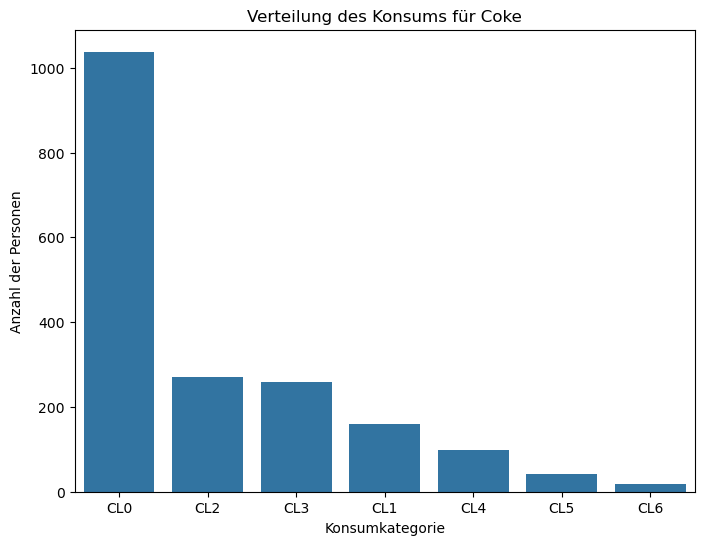

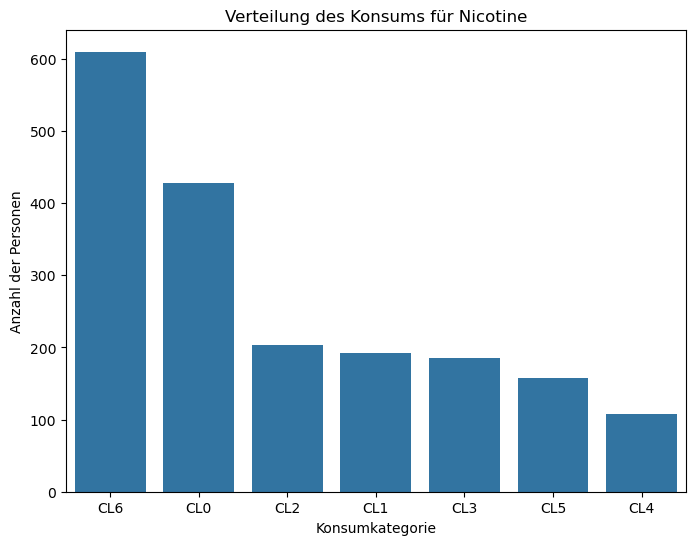

In [217]:
for drug in chosen_drugs:
    plt.figure(figsize=(8, 6))
    
    value_counts = y[drug].value_counts().sort_values(ascending=False)
    
    sns.countplot(x=y[drug], order=value_counts.index)
    
    plt.title(f"Verteilung des Konsums für {drug.capitalize()}")
    plt.xlabel('Konsumkategorie')
    plt.ylabel('Anzahl der Personen')
    plt.show()


### Funktion, die Modelle erstellt und evaluiert

--> Zielvariable für die gewählte Droge

In [218]:
drug_name = "cannabis"
y_selected = y[drug_name]

### Train-Test-Split

--> Splitting zu 80% Trainingsdaten und 20% Testdaten

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y_selected, test_size=0.85, random_state=42)

### Verifizieren des Splits

In [220]:
print("\nTrainingsdaten (Features) : ", X_train.shape)
print("Testdaten (Features) : ", X_test.shape)



Trainingsdaten (Features) :  (282, 9)
Testdaten (Features) :  (1603, 9)


## Erstellen und Trainieren verschiedener Modelle
### Random Forest Modell

In [221]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


### Logistische Regression Modell


In [222]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)

### SVM Modell

In [223]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

### Ergebnisse für alle Modelle

In [224]:
models = ['Random Forest', 'Logistische Regression', "SVM"]
accuracies = [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_svm)
    ]
classification_reports = [
        classification_report(y_test, y_pred_rf, zero_division=0),
        classification_report(y_test, y_pred_logreg, zero_division=0),
        classification_report(y_test, y_pred_svm, zero_division=0)
    ]
f1_scores = [
    f1_score(y_test, y_pred_rf, average='macro'),
    f1_score(y_test, y_pred_logreg, average='macro'),
    f1_score(y_test, y_pred_svm, average='macro')
]

### Ausgabe der Genauigkeit und Klassifikationsberichte

In [225]:
for i in range(len(models)):
    print(f"\n{models[i]} - Genauigkeit: {accuracies[i]:.3f}")
    print(f"\n{models[i]} - F1-Score: {f1_scores[i]:.3f}") 
    #print(f"\n{models[i]} - Klassifikationsbericht:")
    #print(classification_reports[i])


Random Forest - Genauigkeit: 0.362

Random Forest - F1-Score: 0.235

Logistische Regression - Genauigkeit: 0.396

Logistische Regression - F1-Score: 0.227

SVM - Genauigkeit: 0.407

SVM - F1-Score: 0.221


### Vergleich der Genauigkeiten

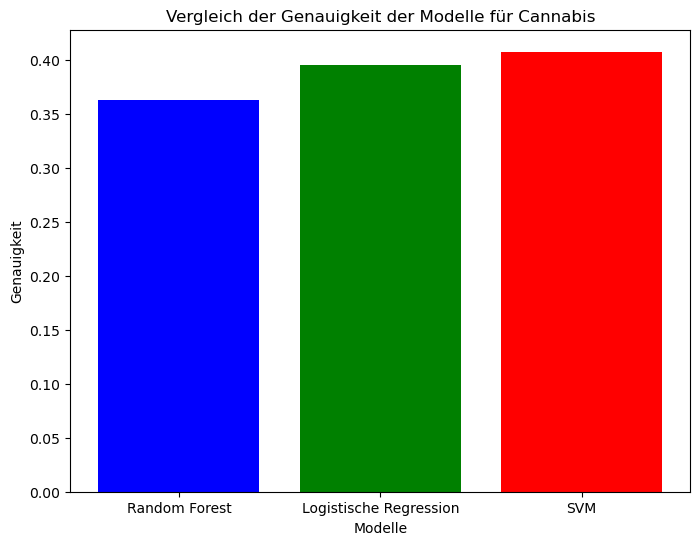

In [226]:
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Modelle')
plt.ylabel('Genauigkeit')
plt.title(f'Vergleich der Genauigkeit der Modelle für {drug_name.capitalize()}')
plt.show()

### Vergleich der F1-Scores

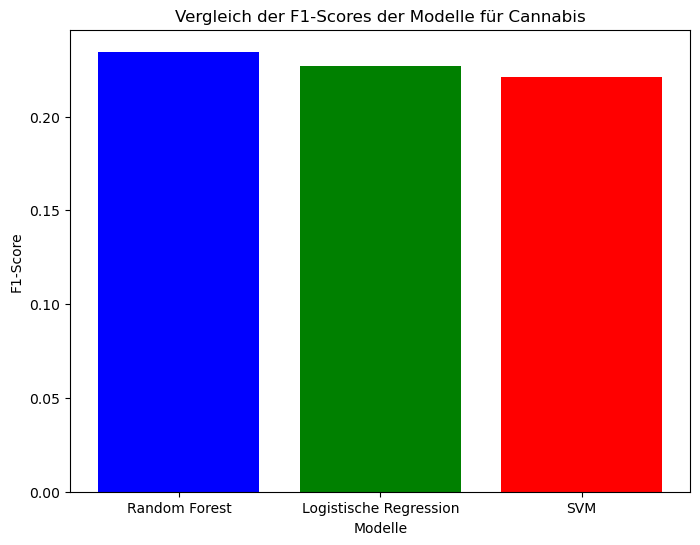

In [227]:
plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, color=['blue', 'green','red'])
plt.xlabel('Modelle')
plt.ylabel('F1-Score')
plt.title(f'Vergleich der F1-Scores der Modelle für {drug_name.capitalize()}')
plt.show()

### Merkmalsgewichtung für trainierte Modelle

Anzahl der Merkmale (9) und Gewichtungen (63) stimmt nicht überein!
Anzahl der Merkmale (9) und Gewichtungen (189) stimmt nicht überein!


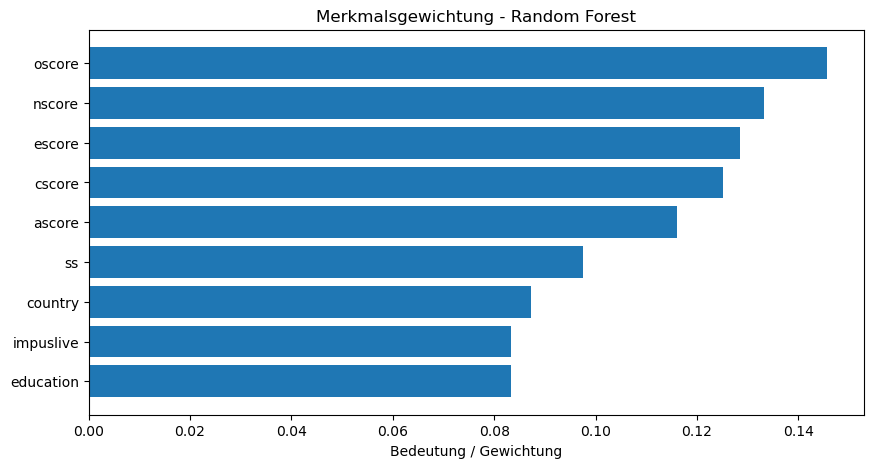

hinweis für inference: es wurden zu beginn features gedroppt


In [228]:
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist() if hasattr(X_train, "columns") else [f"Merkmal {i}" for i in range(num_features)]

def zeige_feature_importance(modellname, gewichtungen):
    gewichtungen = np.array(gewichtungen)

    if len(gewichtungen) != len(feature_names):  
        print(f"Anzahl der Merkmale ({len(feature_names)}) und Gewichtungen ({len(gewichtungen)}) stimmt nicht überein!")
        return  

    sortierte_indices = np.argsort(gewichtungen)
    plt.figure(figsize=(10, 5))
    plt.title(f"Merkmalsgewichtung - {modellname}")
    plt.barh(range(len(gewichtungen)), gewichtungen[sortierte_indices], align="center")
    plt.yticks(range(len(gewichtungen)), np.array(feature_names)[sortierte_indices])
    plt.xlabel("Bedeutung / Gewichtung")
    plt.show()

if hasattr(logreg_model, "coef_") and logreg_model.coef_.size > 0:
    zeige_feature_importance("Logistische Regression", np.ravel(logreg_model.coef_))

if hasattr(svm_model, "coef_") and svm_model.coef_.size > 0:
    zeige_feature_importance("SVM (Linear)", np.ravel(svm_model.coef_))

if hasattr(rf_model, "feature_importances_") and rf_model.feature_importances_.size > 0:
    zeige_feature_importance("Random Forest", rf_model.feature_importances_)

print("hinweis für inference: es wurden zu beginn features gedroppt")


### Konfusionsmatrix für jedes Modell

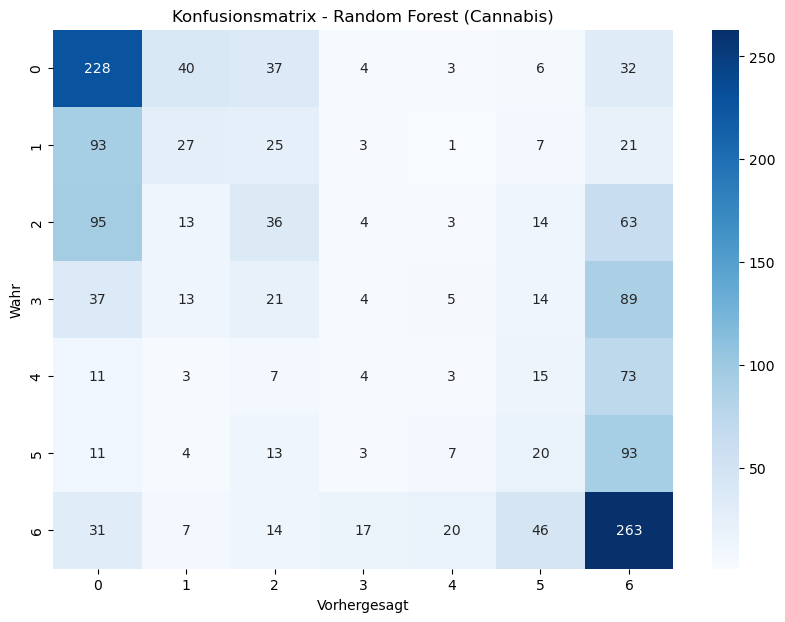

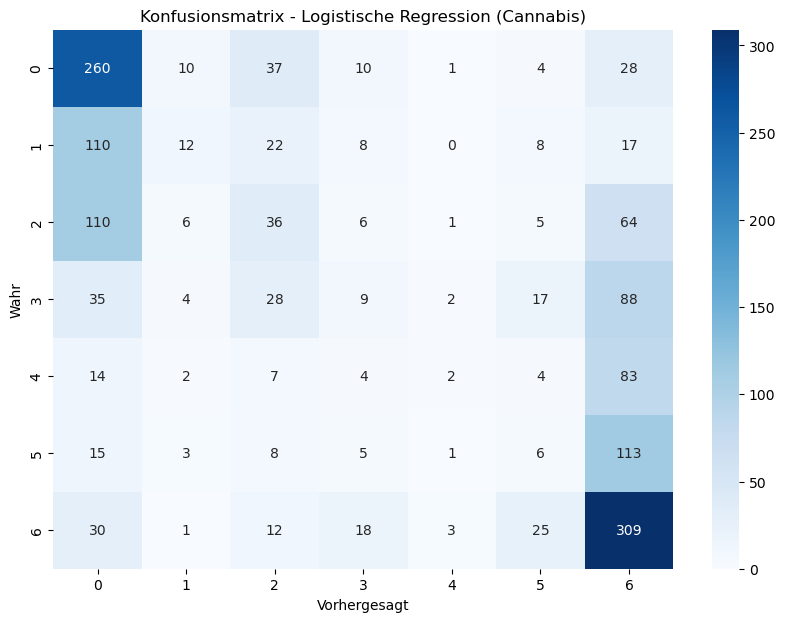

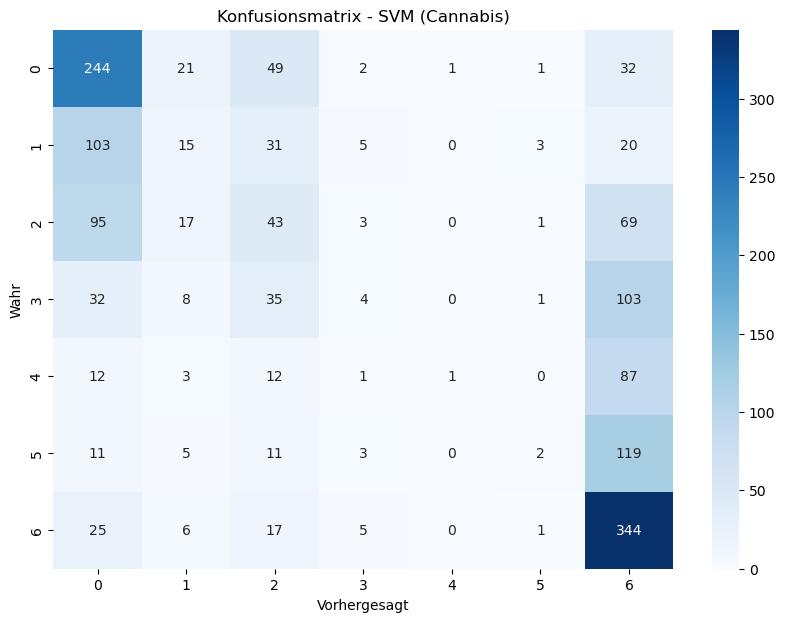

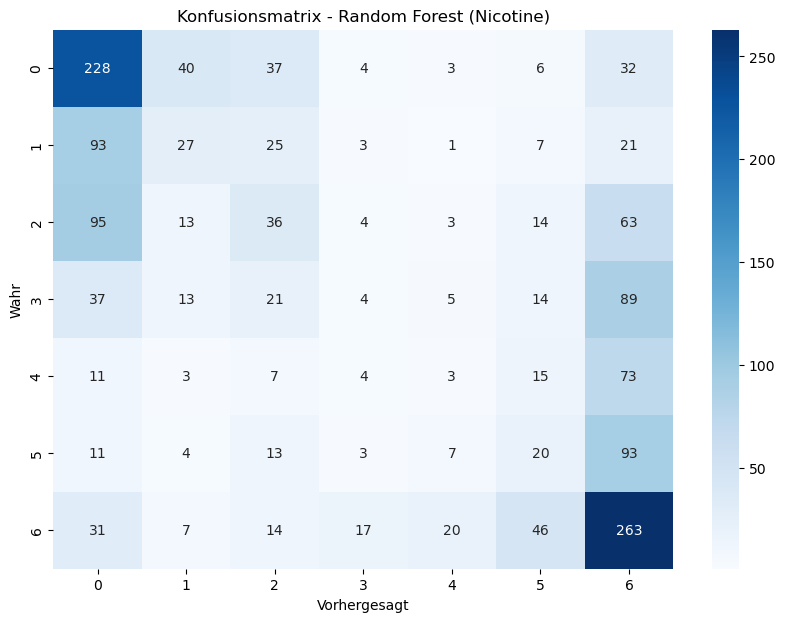

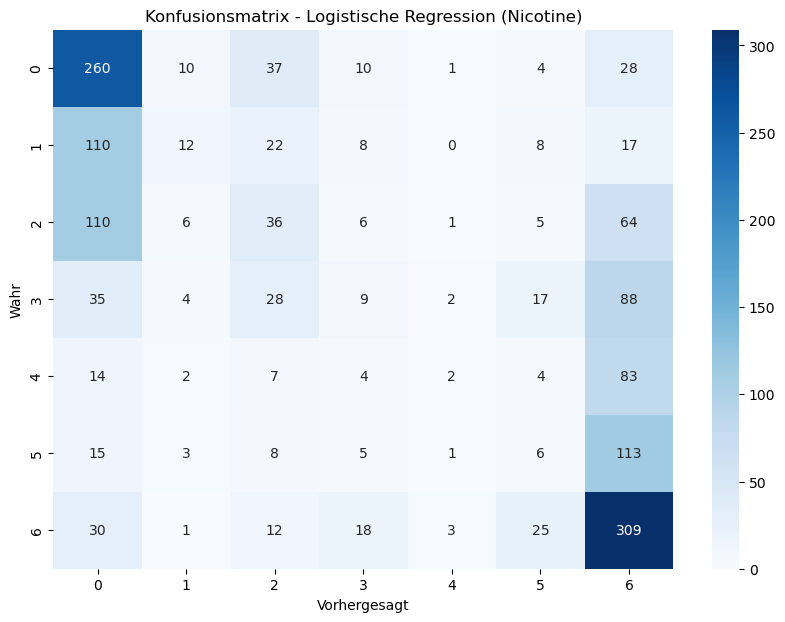

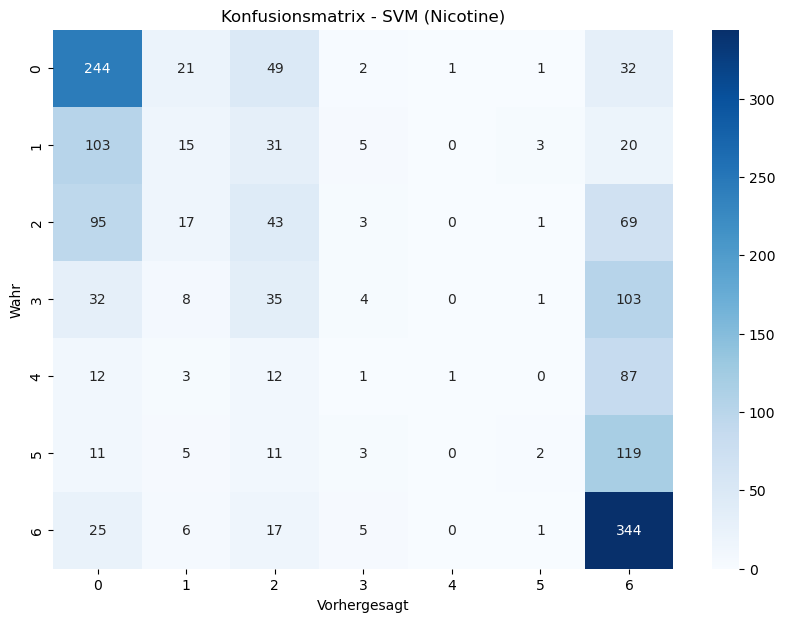

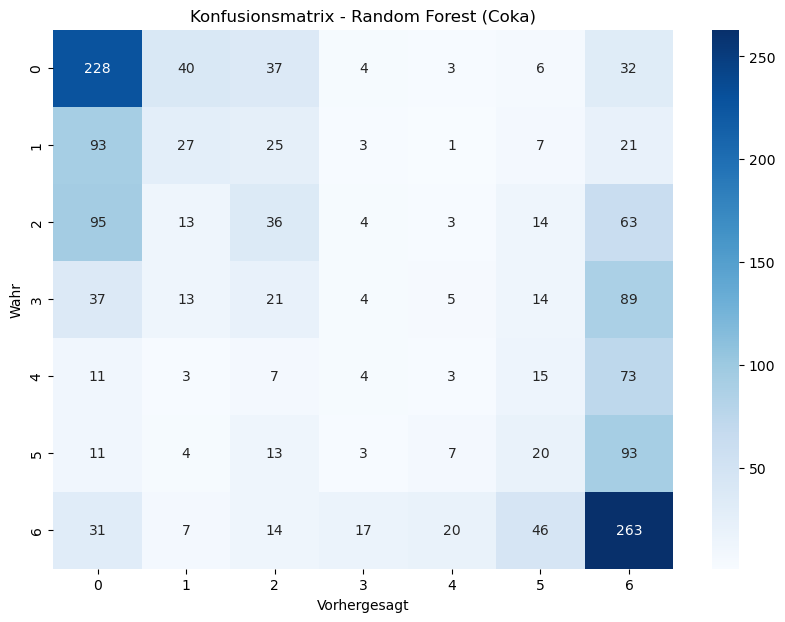

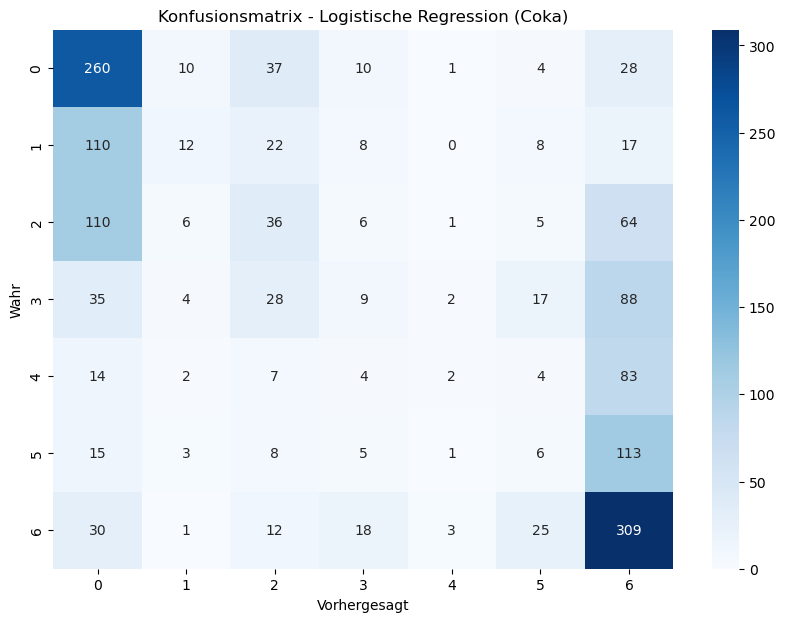

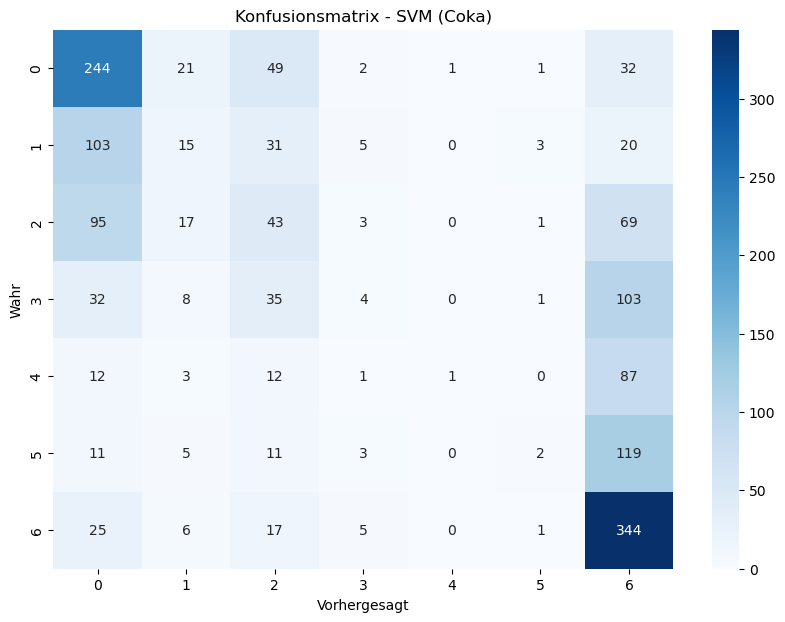

In [229]:
drug_names = ["Cannabis", "Nicotine", "Coka"]
models = ["Random Forest", "Logistische Regression", "SVM"]
predictions = [y_pred_rf, y_pred_logreg, y_pred_svm]  # Alle Modellvorhersagen

for drug in drug_names:  
    for i in range(len(models)):  
        conf_matrix = confusion_matrix(y_test, predictions[i])

        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

        plt.title(f"Konfusionsmatrix - {models[i]} ({drug})")
        plt.xlabel("Vorhergesagt")
        plt.ylabel("Wahr")
        plt.show()



### Überprüfung der Klassen in den Vorhersagen

In [230]:
unique_classes = np.unique(y_test)
print("\nVorhergesagte Klassen:", np.unique(y_pred_rf))
print("Echte Klassen:", unique_classes)


Vorhergesagte Klassen: ['CL0' 'CL1' 'CL2' 'CL3' 'CL4' 'CL5' 'CL6']
Echte Klassen: ['CL0' 'CL1' 'CL2' 'CL3' 'CL4' 'CL5' 'CL6']


## Data Preparation

### Überprüfen auf Duplikate

In [231]:
print("Anzahl Duplikate im Datensatz: ", sum(X.duplicated()))

if sum(X.duplicated()) == 0: 
    print("Keine Duplikate im Datensatz.")

Anzahl Duplikate im Datensatz:  0
Keine Duplikate im Datensatz.


### Übersicht zu fehlenden Werten

In [232]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   education  1885 non-null   float64
 1   country    1885 non-null   float64
 2   nscore     1885 non-null   float64
 3   escore     1885 non-null   float64
 4   oscore     1885 non-null   float64
 5   ascore     1885 non-null   float64
 6   cscore     1885 non-null   float64
 7   impuslive  1885 non-null   float64
 8   ss         1885 non-null   float64
dtypes: float64(9)
memory usage: 132.7 KB
None


Keine fehlenden oder doppelten Werte im Datensatz vorhanden. Somit müssen keine Einträge gelöscht / entfernt werden.